Github Issue: https://github.com/dmwm/CRABServer/issues/7312

This Notebook show plots and queries of the following tasks:
- Task1 - Sum of "WallClockHr" by "CMSPrimaryDataTier
- Task2 - Sum of "WallClockHr" by "Type" ['production', 'analysis']
- Task3 - Sum of "WallClockHr" filter "Type"['analysis'] by "CRAB_DataBlock" ['MCFakeBlock', Else] (MC Prod vs Analysis)
- Task4 - Average CPU Efficiency group by "RecordTime" each hour and "InputData" ['onsite', 'offsite']
- Task5 - Success rate of the "Type" ['analysis']

Note: The raw data is filtered to drop_duplicates(["GlobalJobId"]) and Status IN ('Completed', 'Removed', 'Held', 'Error') of the date May 1st

In [1]:
import time
from datetime import datetime, date, timedelta

import click
import numpy as np
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    first,
)
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"

In [79]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("CMSSite", StringType(), nullable=True),
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("OverflowType", StringType(), nullable=True),
                        StructField("WallClockHr", DoubleType(), nullable=True),
                        StructField("CoreHr", DoubleType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("ExitCode", LongType(), nullable=True),
                        StructField("Chirp_CRAB3_Job_ExitCode", LongType(), nullable=True),
                        StructField("Chirp_WMCore_cmsRun_ExitCode", LongType(), nullable=True),
                        StructField("JobExitCode", LongType(), nullable=True)
                    ]
                ),
            ),
        ]
    )
def get_candidate_files(
    start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER,
):
    """
    Returns a list of hdfs folders that can contain data for the given dates.
    """
    st_date = start_date - timedelta(days=3)
    ed_date = end_date + timedelta(days=3)
    days = (ed_date - st_date).days
    #what is pre_candidate_files for????
    pre_candidate_files = [
        "{base}/{day}{{,.tmp}}".format(
            base=base, day=(st_date + timedelta(days=i)).strftime("%Y/%m/%d")
        )
        for i in range(0, days)
    ]
    sc = spark.sparkContext
    # The candidate files are the folders to the specific dates,
    # but if we are looking at recent days the compaction procedure could
    # have not run yet so we will considerate also the .tmp folders.
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
        for i in range(0, days)
    ]
    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    return candidate_files


In [80]:
schema = _get_schema()
start_date = datetime(2022, 5, 1)
end_date = datetime(2022, 5, 2)

In [81]:
get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER)

['/project/monitoring/archive/condor/raw/metric/2022/04/28',
 '/project/monitoring/archive/condor/raw/metric/2022/04/29',
 '/project/monitoring/archive/condor/raw/metric/2022/04/30',
 '/project/monitoring/archive/condor/raw/metric/2022/05/01',
 '/project/monitoring/archive/condor/raw/metric/2022/05/02',
 '/project/monitoring/archive/condor/raw/metric/2022/05/03',
 '/project/monitoring/archive/condor/raw/metric/2022/05/04']

In [82]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        ).select("data.*")
        .filter(
            f"""Status IN ('Completed', 'Removed', 'Held', 'Error') 
          AND RecordTime >= {start_date.timestamp() * 1000}
          AND RecordTime < {end_date.timestamp() * 1000}
          """
        )
        .drop_duplicates(["GlobalJobId"])
    )

spark.conf.set("spark.sql.session.timeZone", "UTC")

In [83]:
raw_df.printSchema()

root
 |-- CMSSite: string (nullable = true)
 |-- RecordTime: long (nullable = true)
 |-- InputData: string (nullable = true)
 |-- CMSPrimaryDataTier: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- OverflowType: string (nullable = true)
 |-- WallClockHr: double (nullable = true)
 |-- CoreHr: double (nullable = true)
 |-- CpuTimeHr: double (nullable = true)
 |-- RequestCpus: long (nullable = true)
 |-- Type: string (nullable = true)
 |-- CRAB_DataBlock: string (nullable = true)
 |-- GlobalJobId: string (nullable = true)
 |-- ExitCode: long (nullable = true)
 |-- Chirp_CRAB3_Job_ExitCode: long (nullable = true)
 |-- Chirp_WMCore_cmsRun_ExitCode: long (nullable = true)
 |-- JobExitCode: long (nullable = true)



# TASK 1

### Sum of "WallClockHr" by "CMSPrimaryDataTier"

In [11]:
df1 = raw_df.groupby([col("CMSPrimaryDataTier")])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"))\
            .sort("Sum_WallClockHr")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df1.show(10)


In [29]:
df11 = raw_df.groupby([col("CMSPrimaryDataTier")])\
            .agg(_sum("CoreHr").alias("Sum_CoreHr"))\
            .sort("Sum_CoreHr")
df11.show(10)


+--------------------+------------------+
|  CMSPrimaryDataTier|        Sum_CoreHr|
+--------------------+------------------+
|GEN-SIM-DIGI-RAW-...| 35.97555555555556|
|                RECO|  665.338888888889|
|GEN-SIM-DIGI-RAW-...|2434.7616666666686|
|          NANOAODSIM| 2656.410277777777|
|            RAW-RECO| 4378.294999999997|
|                 LHE| 4432.561666666667|
|        GEN-SIM-RECO| 4629.544722222223|
|                FEVT|5748.5516666666645|
|         GEN-SIM-RAW|10363.258055555547|
|    GEN-SIM-DIGI-RAW|  24029.8486111111|
+--------------------+------------------+
only showing top 10 rows



In [12]:
df1 = df1.toPandas()

In [30]:
df11 = df11.toPandas()

In [32]:
sumWallClockHr = df1.Sum_WallClockHr.values.tolist()
dataTier = df1.CMSPrimaryDataTier.values.tolist()

sumWc = sum(sumWallClockHr)
data = []
legends = []
others = 0
otherTiers = []

for i in range(len(sumWallClockHr)):
    percent = sumWallClockHr[i]*100/sumWc
    if(percent<1):
        others+=percent
        otherTiers.append(dataTier[i]+": %.3f"%percent+"%")
    else:
        data.append(percent)
        legends.append(dataTier[i])
data.append(others)
legends.append("Others")

In [33]:
sumCoreHr = df11.Sum_CoreHr.values.tolist()
dataTier1 = df11.CMSPrimaryDataTier.values.tolist()

sumC = sum(sumCoreHr)
data1 = []
legends1 = []
others1 = 0
otherTiers1 = []

for i in range(len(sumCoreHr)):
    percent1 = sumCoreHr[i]*100/sumC
    if(percent1<1):
        others1+=percent1
        otherTiers1.append(dataTier1[i]+": %.3f"%percent1+"%")
    else:
        data1.append(percent1)
        legends1.append(dataTier1[i])
data1.append(others1)
legends1.append("Others")

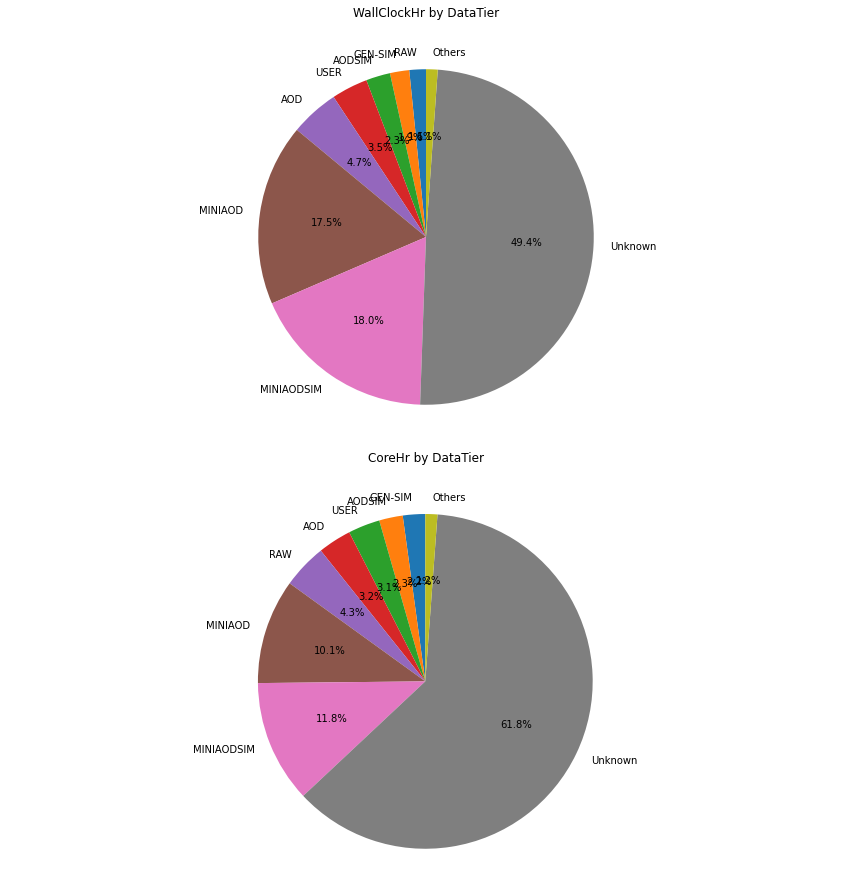

Other tiers for WallclockHr
GEN-SIM-DIGI-RAW-HLTDEBUG: 0.001%
RECO: 0.015%
GEN-SIM-DIGI-RAW-MINIAOD: 0.039%
GEN-SIM-RECO: 0.044%
LHE: 0.057%
NANOAODSIM: 0.060%
RAW-RECO: 0.068%
GEN-SIM-RAW: 0.093%
FEVT: 0.112%
ALCARECO: 0.199%
GEN-SIM-DIGI-RAW: 0.431%


Other tiers for CoreHr
GEN-SIM-DIGI-RAW-HLTDEBUG: 0.000%
RECO: 0.006%
GEN-SIM-DIGI-RAW-MINIAOD: 0.024%
NANOAODSIM: 0.026%
RAW-RECO: 0.042%
LHE: 0.043%
GEN-SIM-RECO: 0.045%
FEVT: 0.056%
GEN-SIM-RAW: 0.100%
GEN-SIM-DIGI-RAW: 0.233%
ALCARECO: 0.588%


In [59]:
import matplotlib.pyplot as plt
from matplotlib import cm
fig1, ax1 = plt.subplots(nrows=2,ncols=1, figsize=(15, 15))
ax1[0].pie(data, labels=legends, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1[0].set_title('WallClockHr by DataTier', y=1.08)
ax1[0].axis('equal')

ax1[1].pie(data1, labels=legends1, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1[1].set_title('CoreHr by DataTier', y=1.08)
ax1[1].axis('equal')

# plt.savefig('final-wc-core-datatier.png')
plt.show()
print("Other tiers for WallclockHr")
print(*otherTiers, sep = "\n")

print("\n\nOther tiers for CoreHr")
print(*otherTiers1, sep = "\n")

# TASK 2

### Sum of "WallClockHr" by "Type" ['production', 'analysis']

In [60]:
df2 = raw_df.filter(col('Type').isin(['production', 'analysis']))\
            .groupby([col('Type')])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"),\
                 _sum("CoreHr").alias("Sum_CoreHr"))


In [61]:
df2.show()

+----------+------------------+------------------+
|      Type|   Sum_WallClockHr|        Sum_CoreHr|
+----------+------------------+------------------+
|production|1730747.9052777775|6429590.3980555525|
|  analysis|2642536.8961111093|3855047.2286111135|
+----------+------------------+------------------+



In [62]:
df2 = df2.toPandas()

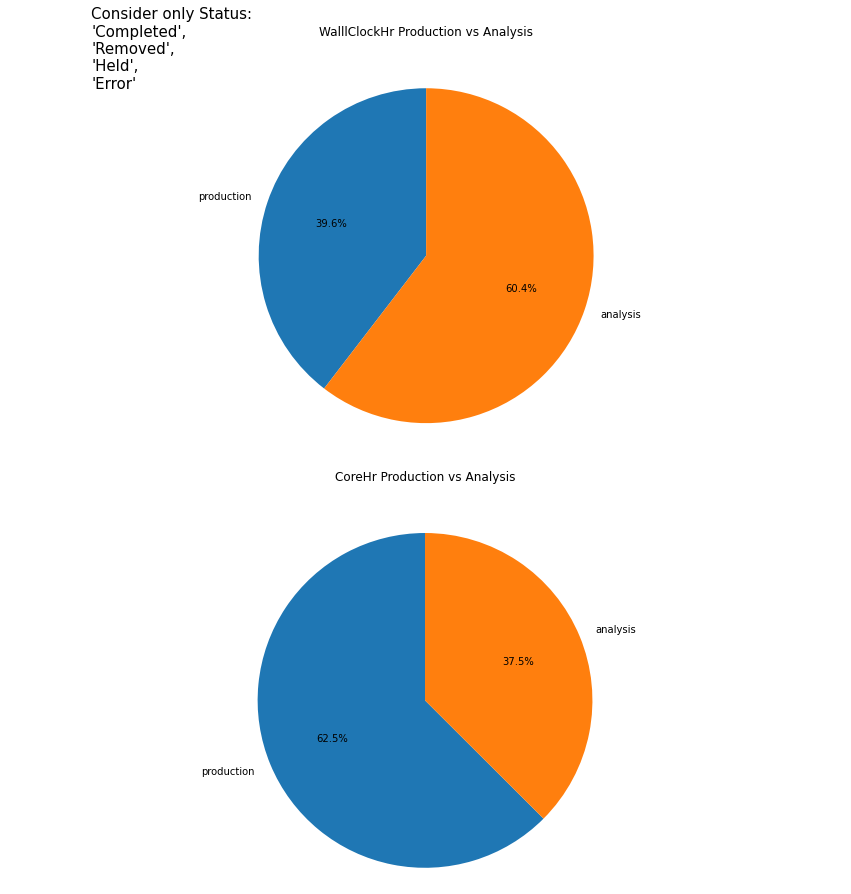

In [68]:
sumCoreHr2 = df2.Sum_CoreHr.values.tolist()
sumWallClockHr2 = df2.Sum_WallClockHr.values.tolist()
dataType = df2.Type.values.tolist()

fig2, ax2 = plt.subplots(nrows=2,ncols=1, figsize=(15, 15))
ax2[0].pie(sumWallClockHr2, labels=dataType, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2[0].axis('equal') 
ax2[0].set_title('WalllClockHr Production vs Analysis', y=1.08)

ax2[1].pie(sumCoreHr2, labels=dataType, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax2[1].axis('equal') 
ax2[1].set_title('CoreHr Production vs Analysis', y=1.08)

ax2[0].text(-2, 1,   "Consider only Status:\n'Completed',\n'Removed',\n'Held',\n'Error'", fontsize=15)
plt.savefig('final-wc-core-prod-analysis.png')
plt.show()




# TASK 3

### Sum of "WallClockHr" filter "Type"['analysis'] by "CRAB_DataBlock" ['MCFakeBlock', Else]

In [69]:
#sum wallclock analysis vs mc production -> mc is analysis w/o input data 
df3 = raw_df.filter(col('Type')=='analysis')\
            .withColumn('isMcprod', when(col('CRAB_DataBlock')=='MCFakeBlock', 'mc').otherwise('notMc'))\
            .groupby([col('isMcprod')])\
            .agg(_sum("WallClockHr").alias("Sum_WallClockHr"),\
                 _sum("CoreHr").alias("Sum_CoreHr"))


In [70]:
df3.show()

+--------+------------------+------------------+
|isMcprod|   Sum_WallClockHr|        Sum_CoreHr|
+--------+------------------+------------------+
|   notMc|2250815.6961111105| 3463326.028611112|
|      mc|391733.17500000005|391733.17500000005|
+--------+------------------+------------------+



In [71]:
df3 = df3.toPandas()

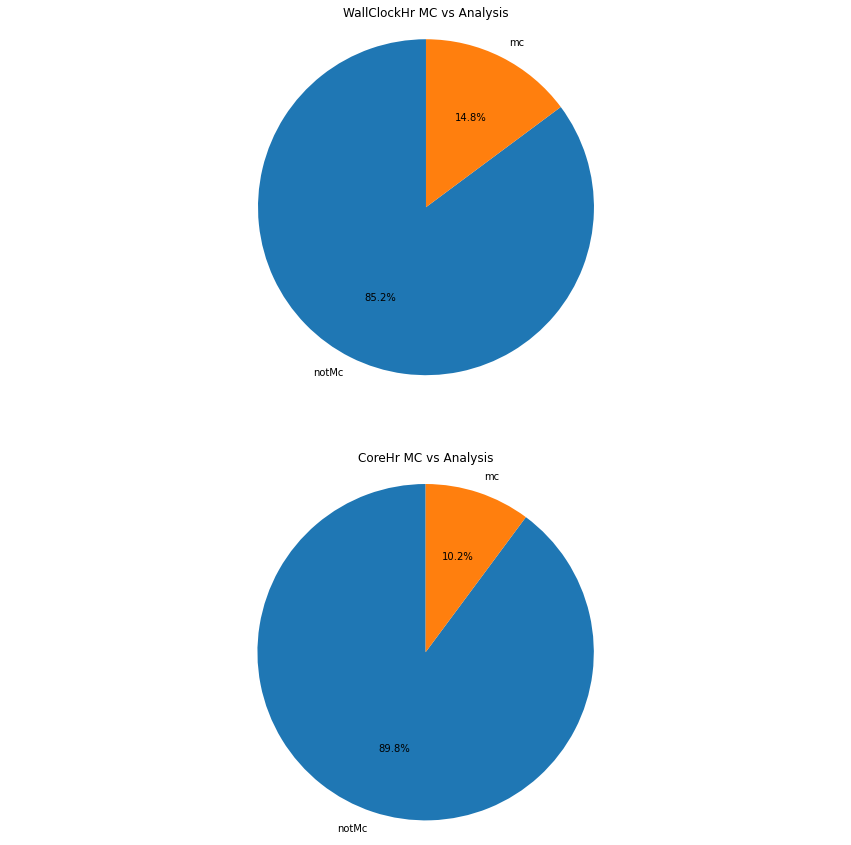

In [73]:
sumCoreHr3 = df3.Sum_CoreHr.values.tolist()
sumWallClockHr3 = df3.Sum_WallClockHr.values.tolist()
isMcProd = df3.isMcprod.values.tolist()

fig3, ax3 = plt.subplots(nrows=2,ncols=1, figsize=(15, 15))
ax3[0].pie(sumWallClockHr3, labels=isMcProd, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax3[0].axis('equal') 
ax3[0].set_title('WallClockHr MC vs Analysis')

ax3[1].pie(sumCoreHr3, labels=isMcProd, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax3[1].axis('equal') 
ax3[1].set_title('CoreHr MC vs Analysis')

ax2[0].text(-2, 1,   "Consider only Status:\n'Completed',\n'Removed',\n'Held',\n'Error'", fontsize=15)
plt.savefig('final-wc-core-mc-analysis.png')
plt.show()

# TASK 4

### Average CPU Efficiency group by "RecordTime" each hour and "InputData" ['onsite', 'offsite']

Note: Average CPU Efficiency = SUM(CpuTimeHr)/SUM(WallClockHr * RequestCpus)

In [74]:
from pyspark.sql.functions import from_unixtime, when, col
from pyspark.sql.types import *
from pyspark.sql.functions import date_format
import pandas as pd

In [78]:
raw_df.select(col("RecordTime")).limit(20).show()

+-------------+
|   RecordTime|
+-------------+
|1651386242000|
|1651386242000|
|1651412162000|
|1651412162000|
|1651412162000|
|1651411922000|
|1651415761000|
|1651415761000|
|1651415761000|
|1651412162000|
|1651384801000|
|1651384801000|
|1651384801000|
|1651422991000|
|1651398481000|
|1651400642000|
|1651372510000|
|1651372551000|
|1651402081000|
|1651366081000|
+-------------+



In [76]:
#avg cpu eff → read mode (onsite vs offsite)
raw_df.createOrReplaceTempView("day")
df4 = spark.sql('SELECT     DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH") AS timestamp,\
                            day.InputData AS inputData, \
                            SUM(day.CpuTimeHr) AS sumWallclockHr, \
                            SUM(day.WallClockHr*day.RequestCpus) as sumWallByReqCpus, \
                            SUM(day.CpuTimeHr)/SUM(day.WallClockHr*day.RequestCpus) AS avgCpuEff_Wall, \
                            SUM(day.CoreHr) as sumCoreHr, \
                            SUM(day.CpuTimeHr)/SUM(day.CoreHr) AS avgCpuEff_Core \
                    FROM day \
                    GROUP BY DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH"), inputData\
                    ORDER BY DATE_FORMAT(FROM_UNIXTIME(day.RecordTime/1000), "HH")')




In [77]:
df4.show(10)

+---------+---------+------------------+------------------+------------------+------------------+------------------+
|timestamp|inputData|    sumWallclockHr|  sumWallByReqCpus|    avgCpuEff_Wall|         sumCoreHr|    avgCpuEff_Core|
+---------+---------+------------------+------------------+------------------+------------------+------------------+
|       00|  Offsite|12040.659999999994|15678.095833333331|0.7679924990890952|15678.095833333331|0.7679924990890952|
|       00|   Onsite| 215178.5972222222| 375120.8061111111|0.5736247995758629| 375120.8061111111|0.5736247995758629|
|       01|  Offsite| 18165.78805555555| 17987.82388888889| 1.009893590673666| 17987.82388888889| 1.009893590673666|
|       01|   Onsite|       253461.7875| 428001.2844444445|0.5921986608731775| 428001.2844444445|0.5921986608731775|
|       02|  Offsite|13906.716944444437| 17003.58583333333|0.8178696588329103| 17003.58583333333|0.8178696588329103|
|       02|   Onsite|221182.92583333323| 376106.4702777777|0.588

In [78]:
df4Onsite = df4.filter(col('inputData')=='Onsite').toPandas()
df4Offsite = df4.filter(col('inputData')=='Offsite').toPandas()

KeyboardInterrupt: 

In [ ]:
df4OnsiteAvg_Wall = df4Onsite.avgCpuEff_Wall.values.tolist()
df4OffsiteAvg_Wall = df4Offsite.avgCpuEff_Wall.values.tolist()
# df4OnsiteAvg_Core = df4Onsite.avgCpuEff_Core.values.tolist()
# df4OffsiteAvg_Core = df4Offsite.avgCpuEff_Core.values.tolist()

In [ ]:
from statistics import mean
meanOffsite_Wall=mean(df4OnsiteAvg_Wall)
meanOnsite_Wall=mean(df4OnsiteAvg_Wall)
meanOffsiteList = []
meanOnsiteList = []
for i in range(24):
    meanOffsiteList.append(meanOffsite_Wall)
    meanOnsiteList.append(meanOnsite_Wall)

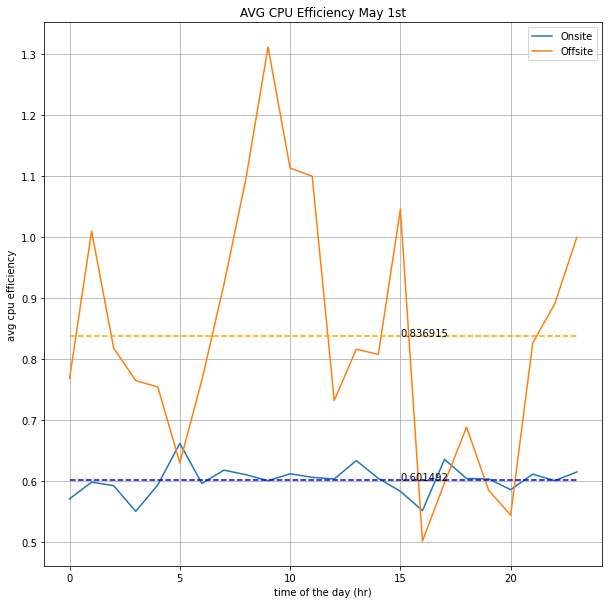

In [53]:
# Data for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
hour = np.arange(0, 24, 1)


fig, ax = plt.subplots()
ax.plot(hour, df4OnsiteAvg_Wall, color="blue", label='Wall_Onsite')
ax.plot(hour, df4OffsiteAvg_Wall, color="orange", label='Wall_Offsite')

# ax.plot(hour, df4OnsiteAvg_Core, color="green", label='Core_Onsite')
# ax.plot(hour, df4OffsiteAvg_Core, color="red", label='Core_Offsite')

ax.plot(hour, meanOnsiteList, color="blue", linestyle="--")
ax.plot(hour, meanOffsiteList, color="orange", linestyle="--")

ax.text(15,meanOnsite,'%f' % (meanOnsite))
ax.text(15,meanOffsite,'%f' % (meanOffsite))



ax.set(xlabel='time of the day (hr)', ylabel='avg cpu efficiency',
       title='AVG CPU Efficiency May 1st')
ax.grid()
plt.legend()

# plt.savefig('final-avg-cpueff-onsite-offsite.png')
plt.show()

# TASK 5

### Success rate of the "Type" ['analysis']

The success rate is converted from the "Chirp_CRAB3_Job_ExitCode" where 0 == 'Success', Else = 'Fail'

In [106]:
#analysis success rate
from pyspark.sql.functions import count as _count
df5 = raw_df.withColumn('exitCode', 
                        when((col("Chirp_CRAB3_Job_ExitCode")!=0) & (col("Chirp_CRAB3_Job_ExitCode").isNotNull()), 1)\
                        .otherwise(col("Chirp_CRAB3_Job_ExitCode")))\
            .select('exitCode', col('Type'), col('CoreHr'))\
            .filter(col("Type")=="analysis")\
            .groupby('exitCode')\
            .agg(_count(when(col('exitCode')==1, True)).alias('countFail'),\
                 _count(when(col('exitCode')==0, True)).alias('countSuccess'),\
                 _sum(col('CoreHr')).alias("Sum_CoreHr"))


In [107]:
df5.show()

+--------+---------+------------+-----------------+
|exitCode|countFail|countSuccess|       Sum_CoreHr|
+--------+---------+------------+-----------------+
|       0|        0|      166782|765476.6747222224|
|    null|        0|           0|2535692.799722221|
|       1|   154587|           0| 553879.173055556|
+--------+---------+------------+-----------------+



In [127]:
countFail = df5.collect()[2][1]
countSuccess = df5.collect()[0][2]

In [130]:
sumCoreHr = list(df5.select('Sum_CoreHr').toPandas()['Sum_CoreHr'])

In [131]:
sumCoreHr

[765477.9288888901, 2535691.928055554, 553879.1730555554]

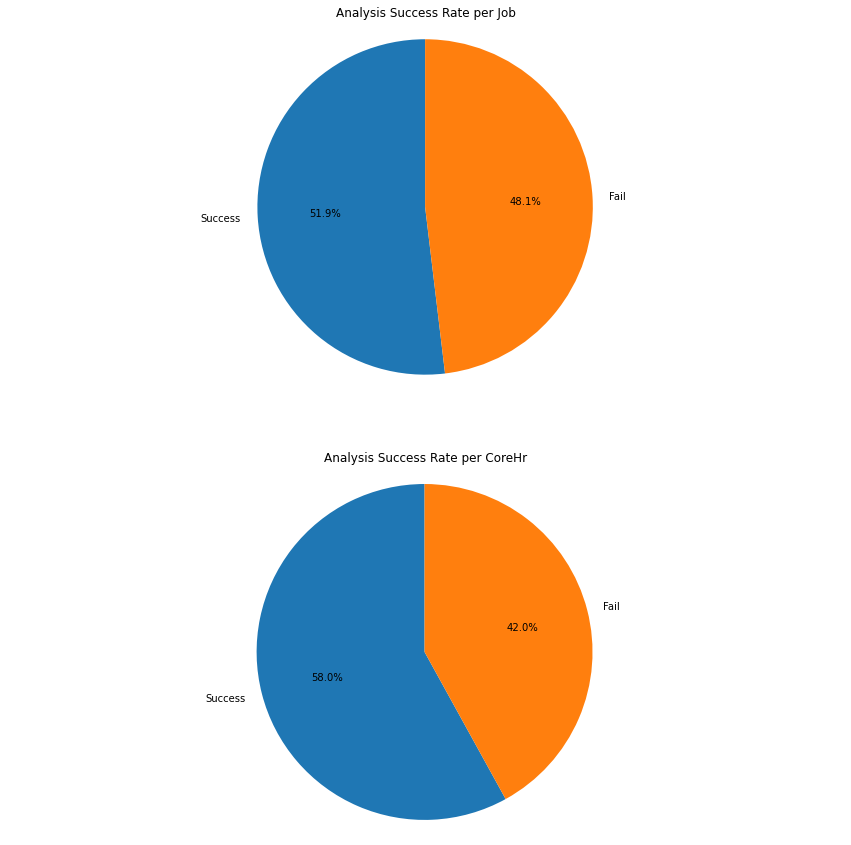

In [133]:
plt.rcParams["figure.figsize"] = (10,10)
fig5, ax5 = plt.subplots(nrows=2,ncols=1, figsize=(15, 15))
figure_title = 'Analysis Success Rate'
ax5[0].pie([countSuccess, countFail], labels=["Success", "Fail"], autopct='%1.1f%%',
        shadow=False, startangle=90)
ax5[0].axis('equal') 
ax5[0].set_title("Analysis Success Rate per Job")

ax5[1].pie([sumCoreHr[0],sumCoreHr[2]], labels=["Success", "Fail"], autopct='%1.1f%%',
        shadow=False, startangle=90)
ax5[1].axis('equal') 
ax5[1].set_title("Analysis Success Rate per CoreHr")

plt.savefig('final-analysis-success-rate-job-corehr.png')
plt.show()

In [103]:
#more details on analysis exitCode
from pyspark.sql.functions import count as _count
df51 = raw_df.select(col('Type'), col('RecordTime'), col('JobExitCode'), col('Chirp_CRAB3_Job_ExitCode'), \
                     col('Chirp_WMCore_cmsRun_ExitCode'), col('ExitCode'))\
            .filter((col("Type")=="analysis")&(col("ExitCode").isNotNull()))\
            .sort('RecordTime')


In [104]:
df51.show(30)

+--------+-------------+-----------+------------------------+----------------------------+--------+
|    Type|   RecordTime|JobExitCode|Chirp_CRAB3_Job_ExitCode|Chirp_WMCore_cmsRun_ExitCode|ExitCode|
+--------+-------------+-----------+------------------------+----------------------------+--------+
|analysis|1651356000000|       null|                       0|                        null|       0|
|analysis|1651356000000|      50660|                   80001|                        null|   50660|
|analysis|1651356000000|       null|                       0|                        null|       0|
|analysis|1651356000000|       null|                       0|                        null|       0|
|analysis|1651356000000|       null|                    8028|                        null|    8028|
|analysis|1651356000000|       null|                       0|                        null|       0|
|analysis|1651356001000|       null|                       0|                        null|       0|


In [102]:
df51.filter(col('Chirp_WMCore_cmsRun_ExitCode').isNotNull()).show(20)

+----+----------+--------+----------------------------+------------------------+-----------+
|Type|RecordTime|ExitCode|Chirp_WMCore_cmsRun_ExitCode|Chirp_CRAB3_Job_ExitCode|JobExitCode|
+----+----------+--------+----------------------------+------------------------+-----------+
+----+----------+--------+----------------------------+------------------------+-----------+



In [137]:
df52 = df51.select(col('ExitCode'))\
            .groupby(col('ExitCode'))\
            .agg(_count(col('ExitCode')).alias("count_ExitCode"))\
            .sort(col("count_ExitCode").desc())

In [138]:
df52 = df52.toPandas()

In [144]:
ExitCode = df52.ExitCode.values.tolist()
CountExitCode = df52.count_ExitCode.values.tolist()
sumExitCode = sum(CountExitCode)

In [145]:
sumExitCode

335565

In [169]:

mainExitCodePercentage = []
legends = []
others = 0
otherExitCodes = []

for i in range(len(CountExitCode)):
    percent = CountExitCode[i]*100/sumExitCode
    if(percent<1):
        others+=percent
        otherExitCodes.append(ExitCode[i])
    else:
        legend ="code %s: %.3f"%(ExitCode[i], percent)+"%"
        
        mainExitCodePercentage.append(percent)
        legends.append(legend)
mainExitCodePercentage.append(others)
legends.append("Others")

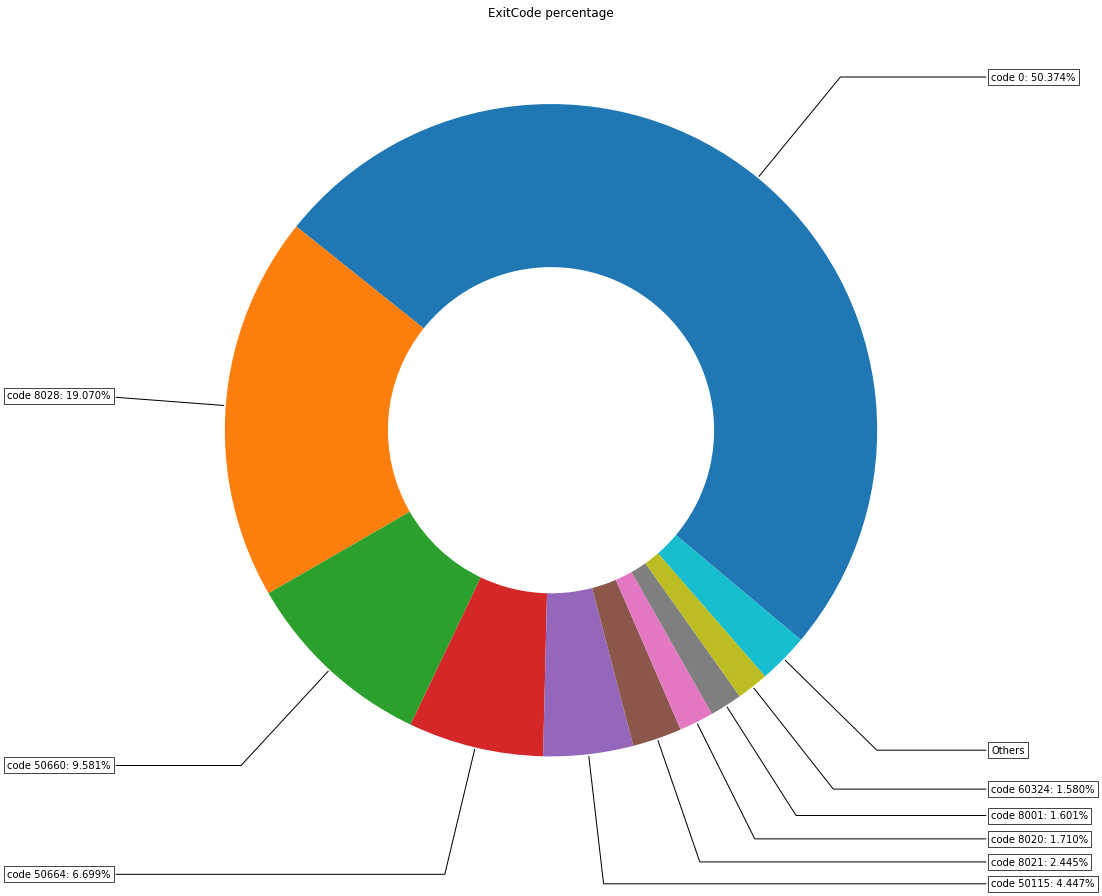

In [170]:
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(aspect="equal"))


wedges, texts = ax.pie(mainExitCodePercentage, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(legends[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("ExitCode percentage")

plt.savefig('exitCode-percentage.png')
plt.show()